# Content-Based Image Retrieval
Recherche d’images par le contenu à partir des caractéristiques:
d’histogrammes couleurs et formes (Moments de Hu)

## Librairies nécessaires

In [1]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

## Source des images

In [2]:
# Liste des images 
DATA = glob.glob('coil-100/obj*.png')
#IMAGES = glob.glob('coil-100/obj*.png')

print("Nombre Total d'images dans la base de données: {nb} ". format(nb = len(DATA)))

Nombre Total d'images dans la base de données: 7200 


In [3]:
# Image requete Exemple
image_requete = 'coil-100/obj1__120.png'
img_bgr = cv2.imread(image_requete)
# Convertir de BGR en RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [4]:
# Enlever l'image requete de la liste

def enleverImageReq(data, img_req):
    '''
    Fonction pour enlever l'image requete de la liste des images
    input: source images, image requete
    output: liste des images sans image requete
    '''
    data.remove(img_req)
    return data
IMAGES = enleverImageReq(DATA, image_requete)

print("Nombre Total d'images dans la base de données: {nb} ". format(nb = len(IMAGES)))

Nombre Total d'images dans la base de données: 7199 


## Calculer les histogrammes de toutes les images de la base

--> calculer l'histogramme à 3 couleurs x 32 de chaque image.
Ensuite nous l'enregistrons dans un dictionnaire dont la clé est l'image et la valeur l'histogramme calculé

In [5]:
def imagesHistogram(data):
    '''
    Fonction pour calculer l'histogramme de toutes les images de la base
    input: liste des images
    ouput: histogram normalisé pour chaque image.
    '''
    
    # Dictionnaire pour stocker les images et leur histogramme correspondant
    HISTOGRAMMES = {}
    
    i = 1

    for idx, elt in enumerate(data):
        # Lire les images par defaut dans l'espace BGR-> Bleu, Green, Red
        img_bgr = cv2.imread(elt)

        # Convertir de BGR en RGB
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Calcul de l'histogramme sur les 3 canaux
        hist_img = cv2.calcHist([img_rgb], [0, 1, 2], None, [32, 32, 32],
                            [0, 256, 0, 256, 0, 256])
        
        # Normaliser histogramme
        hist_normalise = cv2.normalize(hist_img, hist_img).flatten()
        
        if hist_normalise is not None:
            
            # Ajouter à la liste des histogrammes
            HISTOGRAMMES[elt] = hist_normalise
            #print("Image {i}:  {g} Traitée avec succès".format(i=i, g=elt))
            i+=1
    return HISTOGRAMMES
            
HISTOGRAMMES = imagesHistogram(IMAGES)

In [6]:
# Taille dictionnaire contenant les histogrammes 7200-1 = nombre d'images base de données
print("Taille dictionnaire contenant les histogrammes:", len(HISTOGRAMMES))

Taille dictionnaire contenant les histogrammes: 7199


## Descripteurs de forme: Les moments de Hu

--> Calculer les moments et le vecteur de caractéristiques(7 caracteristiques) de chaque image.

--> Enregistrer le vecteur dans le dictionnaire HUMOMENTS. La clé est l'image et la valeur le vecteur des 7 caracteristiques.

In [7]:
def descripteursHuMoment(data):
    '''
    Fonction pour calculer les moments de hu de toutes les images de la base.
    input: liste des images de la base
    ouput: vecteur de caracteristique pour chaque image.
    '''
    
    # Dictionnaire pour stocker les images et leur caractéristiques de Hu.
    HUMOMENTS = {}
    i = 1
    for idx, elt in enumerate(data):
        
        # Lire les images par defaut dans l'espace BGR-> Bleu, Green, Red
        img_bgr = cv2.imread(elt)

        # Convertir de BGR en Gray
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        
        # Lisser l'image pour reduire les bruits: filtre 
        img_gray = cv2.blur(img_gray, (3,3))

        # Transformer l'image en image binaire car les images sont sur fond noir.
        # Methode Seuillage simple : Si le pixel < 128 , alors pixel = 0, sinon pixel = 255.
        _,img_bin = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)

        # Calculer les moments
        img_moments = cv2.moments(img_bin)

        # Calculer les Hu Moments
        img_huMoments = cv2.HuMoments(img_moments)
    
        '''# Mise à l'echelle
        for i in range(0, 7):
            img_huMoments[i] = -1 * math.copysign(1.0, img_huMoments[i]) * math.log10(abs(img_huMoments[i]))
        print(img_huMoments)
        '''
        
        if img_huMoments is not None:
            
            # Ajouter au dictionnaire des moments. cle = image, valeur = vecteur hu moment
            HUMOMENTS[elt] = img_huMoments
            #print(img_huMoments)
            #print(' ')
            #print("-> Image {i}:  {g} Traitée avec succès".format(i=i, g=elt))
            #print(' ')

            
            i+=1
    return HUMOMENTS
            
HUMOMENTS = descripteursHuMoment(IMAGES)

In [8]:
# Taille dictionnaire contenant les vecteurs Hu 7200-1 = nombre d'images base de données
print("Taille dictionnaire des vecteurs de caracteristiques des hu moments:", len(HUMOMENTS))

Taille dictionnaire des vecteurs de caracteristiques des hu moments: 7199


## Calculer l'histogramme et le vecteur hu moment de l'image à chercher

In [9]:
def histHuImageRequete(data):
    '''
    Fonction pour calculer l'histogramme des images
    input: liste des images
    ouput: histogram normalisé
    '''
    # Lire les images par defaut dans l'espace BGR-> Bleu, Green, Red
    img_bgr = cv2.imread(data)

    # Convertir de BGR en RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Calculer de l'histogramme sur les 3 canaux
    hist_img = cv2.calcHist([img_rgb], [0, 1, 2], None, [32, 32, 32],
                            [0, 256, 0, 256, 0, 256])
    hist_normalise = cv2.normalize(hist_img, hist_img).flatten()
    
    # Calculer les Hu moments 
    # Convertir de BGR en Gray
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Seuillage
    _,img_bin = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)

    # Calculer les moments
    img_moments = cv2.moments(img_bin)

    # Calculate Hu Moments
    img_huMoments = cv2.HuMoments(img_moments)

    return hist_normalise, img_huMoments

hist_requete, hu_requete = histHuImageRequete(image_requete)

## Intersection des histogrammes
-> Comparer l'histogramme de limage requete et celui de chaque image de la base de données. 

-> Renvoyer toutes les distances.

-> Intersection de 2 histogrammes. méthode du Chi-2.

In [10]:
def compareHis(hist1, hist2):
    '''
    Fonction pour comparer deux histogrammes.
    input: histogrammes de tous les images et histogramme de l'image query.
    output: distance entre l'histogramme de l'image query et toutes les images de la base de données
    '''
    
    # Dictionnaire pour stocker les distances entre les histogrammes des images de la base et l'image requete
    DISTANCES_HIST = {}
    
    for (cle, valeur) in hist1.items():
        distance = cv2.compareHist(hist2, valeur, cv2.HISTCMP_CHISQR)
        DISTANCES_HIST[cle] = distance
    return DISTANCES_HIST
        
DISTANCES_HIST = compareHis(HISTOGRAMMES, hist_requete)

In [11]:
# Taille dictionnaire contenant les distances entre les histogrammes. 7200-1 distances = 7200-1 comparaisons
print("Taille dictionnaire des distances entre les histogrammes:", len(DISTANCES_HIST))

Taille dictionnaire des distances entre les histogrammes: 7199


## Distance entre les moments Comparer les vecteurs de caracteristiques d hus
-> Calculer la distance euclidienne classique entre le vecteur de caracteristique de l'image requete et
    celui de chaque image de la base de données

-> Renvoyer toutes les distances.

In [12]:
def compareHu(hu1, hue2):
    '''
    Fonction pour comparer deux hu moments.
    input: histogrammes de tous les images de la base et histogramme de l'image à chercher.
    output: distance entre l'histogramme de l'image de test
    '''
    
    # Dictionnaire pour stocker les distances apres la comparaison
    DISTANCES_HU = {}
    
    for (cle, valeur) in hu1.items():
        # Calculer la distance ecludienne entre deux vecteurs
        dist = np.linalg.norm(valeur - hue2)
        
        # Ajouter a la liste
        DISTANCES_HU[cle] = dist
    return DISTANCES_HU

DISTANCES_HU = compareHu(HUMOMENTS, hu_requete)

In [13]:
# Taille dictionnaire contenant les distances entre les Hu moments. 7200 images = 7200 comparaisons
print("Taille dictionnaire des distances entre vecteurs Hu moments:", len(DISTANCES_HU))

Taille dictionnaire des distances entre vecteurs Hu moments: 7199


## similarité entre deux images en fonction deux distances
-> Attribuer un poids a chaque distance. Par defaut les poids sont egaux w1 = w2 = 0.5. Aucune Distance n'influence plus que l'autre

In [14]:
def similarite(DISTANCES_HIST, DISTANCES_HU):
    '''
    Fonction pour calculer le score de la simularité globale.
    input: Dictionnaire distances hu, et Dictionnaire distances histogramme 
    output: score
    '''
    
    # Dictionnaire pour stocker le score de la simularité
    SCORES = {}

    w_couleur = 0.5 # Poids distance couleur
    w_forme = 0.5 # Poids distance forme
    
    
    for (cle1, valeur1) in DISTANCES_HIST.items():
        for (cle2, valeur2) in DISTANCES_HU.items():
            if cle1 == cle2:
                score = ((w_couleur * valeur1) +(w_forme * valeur2))
                SCORES[cle1] = score
    return SCORES
                
SCORES = similarite(DISTANCES_HIST, DISTANCES_HU)

In [15]:
print("Resultats calcul de simularité Image Requete: {}".format(os.path.splitext(image_requete.split("/")[1])[0]))
print("")
for i, j in SCORES.items():
    print("Score = {a} -> Similarité entre {b} et {c} ".format(a = j, 
                                                               b = os.path.splitext(image_requete.split("/")[1])[0],
                                                               c = os.path.splitext(i.split("/")[1])[0]))

Resultats calcul de simularité Image Requete: obj1__120

Score = 5.151256126497242 -> Similarité entre obj1__120 et obj14__265 
Score = 21.860363769679292 -> Similarité entre obj1__120 et obj2__70 
Score = 0.9200662398096682 -> Similarité entre obj1__120 et obj24__70 
Score = 10.883897022841285 -> Similarité entre obj1__120 et obj54__0 
Score = 0.4827062710976394 -> Similarité entre obj1__120 et obj38__315 
Score = 120.31960255139164 -> Similarité entre obj1__120 et obj32__260 
Score = 14.677707115227694 -> Similarité entre obj1__120 et obj11__245 
Score = 1.215229953610542 -> Similarité entre obj1__120 et obj62__130 
Score = 2.378678562069275 -> Similarité entre obj1__120 et obj49__335 
Score = 16.683581169410054 -> Similarité entre obj1__120 et obj12__160 
Score = 5.036404157586579 -> Similarité entre obj1__120 et obj82__90 
Score = 0.7824349839591171 -> Similarité entre obj1__120 et obj61__0 
Score = 0.5771297219474689 -> Similarité entre obj1__120 et obj34__260 
Score = 4.523552774

Score = 6.189726715008362 -> Similarité entre obj1__120 et obj26__120 
Score = 10.09848215204714 -> Similarité entre obj1__120 et obj99__290 
Score = 0.6343675762027376 -> Similarité entre obj1__120 et obj76__315 
Score = 0.6003302032063624 -> Similarité entre obj1__120 et obj13__65 
Score = 6.427824824829012 -> Similarité entre obj1__120 et obj73__300 
Score = 205.8069729259402 -> Similarité entre obj1__120 et obj10__230 
Score = 0.8961649965174118 -> Similarité entre obj1__120 et obj33__300 
Score = 8.208456042928065 -> Similarité entre obj1__120 et obj17__165 
Score = 0.5627259506927397 -> Similarité entre obj1__120 et obj76__140 
Score = 1.2712789091733334 -> Similarité entre obj1__120 et obj28__210 
Score = 1.0969549426352305 -> Similarité entre obj1__120 et obj47__30 
Score = 31.873431159838212 -> Similarité entre obj1__120 et obj10__25 
Score = 8.463092338041701 -> Similarité entre obj1__120 et obj73__280 
Score = 0.7996218747397682 -> Similarité entre obj1__120 et obj19__335 
S

Score = 0.5002249917619518 -> Similarité entre obj1__120 et obj94__30 
Score = 15.023551106561392 -> Similarité entre obj1__120 et obj68__185 
Score = 20.88085890694297 -> Similarité entre obj1__120 et obj39__50 
Score = 0.4668353419211237 -> Similarité entre obj1__120 et obj40__345 
Score = 6.444345599137135 -> Similarité entre obj1__120 et obj60__155 
Score = 0.9016851258449705 -> Similarité entre obj1__120 et obj96__35 
Score = 0.5984092627802527 -> Similarité entre obj1__120 et obj13__60 
Score = 47.98806678685523 -> Similarité entre obj1__120 et obj97__145 
Score = 0.9673245233546985 -> Similarité entre obj1__120 et obj76__55 
Score = 115.05256538702226 -> Similarité entre obj1__120 et obj66__205 
Score = 147.283621645787 -> Similarité entre obj1__120 et obj18__150 
Score = 457.01529676392084 -> Similarité entre obj1__120 et obj45__215 
Score = 22.158329911886 -> Similarité entre obj1__120 et obj48__185 
Score = 9.804266069527158 -> Similarité entre obj1__120 et obj99__70 
Score =

Score = 1.3521480786540092 -> Similarité entre obj1__120 et obj6__300 
Score = 11.994484664515912 -> Similarité entre obj1__120 et obj75__220 
Score = 4.0878436409626655 -> Similarité entre obj1__120 et obj37__140 
Score = 9.993025046150693 -> Similarité entre obj1__120 et obj99__65 
Score = 5.519130627957605 -> Similarité entre obj1__120 et obj22__10 
Score = 8.620854789307248 -> Similarité entre obj1__120 et obj3__210 
Score = 1.7035503010446629 -> Similarité entre obj1__120 et obj57__90 
Score = 10.851258323575546 -> Similarité entre obj1__120 et obj99__230 
Score = 0.6284236601727929 -> Similarité entre obj1__120 et obj23__135 
Score = 1.074802678323022 -> Similarité entre obj1__120 et obj96__355 
Score = 8.156678414948283 -> Similarité entre obj1__120 et obj20__345 
Score = 40.718607515740004 -> Similarité entre obj1__120 et obj32__40 
Score = 1.342881883491695 -> Similarité entre obj1__120 et obj72__105 
Score = 66.06724692563647 -> Similarité entre obj1__120 et obj74__140 
Score

Score = 37.86749890806926 -> Similarité entre obj1__120 et obj57__180 
Score = 6.1953639214633 -> Similarité entre obj1__120 et obj28__120 
Score = 2.151355294942218 -> Similarité entre obj1__120 et obj36__185 
Score = 3.112417294485708 -> Similarité entre obj1__120 et obj86__250 
Score = 168.40033168030752 -> Similarité entre obj1__120 et obj45__340 
Score = 36.87849699359383 -> Similarité entre obj1__120 et obj9__5 
Score = 2.94494117695437 -> Similarité entre obj1__120 et obj72__350 
Score = 2.853265318797155 -> Similarité entre obj1__120 et obj12__190 
Score = 1.1169451536530726 -> Similarité entre obj1__120 et obj24__60 
Score = 4.340848894954016 -> Similarité entre obj1__120 et obj49__125 
Score = 4.058321389731348 -> Similarité entre obj1__120 et obj68__140 
Score = 16.252535033580962 -> Similarité entre obj1__120 et obj100__280 
Score = 1.2352081242060273 -> Similarité entre obj1__120 et obj47__235 
Score = 2.568933705748143 -> Similarité entre obj1__120 et obj43__260 
Score = 

## Resultats Top N des images les plus proches de l'image Requete: N = 5
-> Trier le dictionnaire par ordre decroissant de la valeur du score

In [16]:
# Recuperation du top N -> items() slicing 
N = 5
resultats = dict(list(sorted(SCORES.items(), key=lambda x: x[1]))[0: N])

In [17]:
#Liste des images pour afficher
t = []

print("Image Requete: {}".format(os.path.splitext(image_requete.split("/")[1])[0]))
print("")
print("Résultats:")
for i, j in resultats.items():
    print("{c} ....... distance = {a} ".format(a = j, c = os.path.splitext(i.split("/")[1])[0]))
    img = cv2.imread(i)
    # Convertir de BGR en RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    t.append(img)
    

Image Requete: obj1__120

Résultats:
obj1__125 ....... distance = 0.1575443226446562 
obj1__130 ....... distance = 0.21116662044632747 
obj1__135 ....... distance = 0.261765302893642 
obj1__115 ....... distance = 0.28347602013762047 
obj1__140 ....... distance = 0.28858486695758623 


## Visualisation

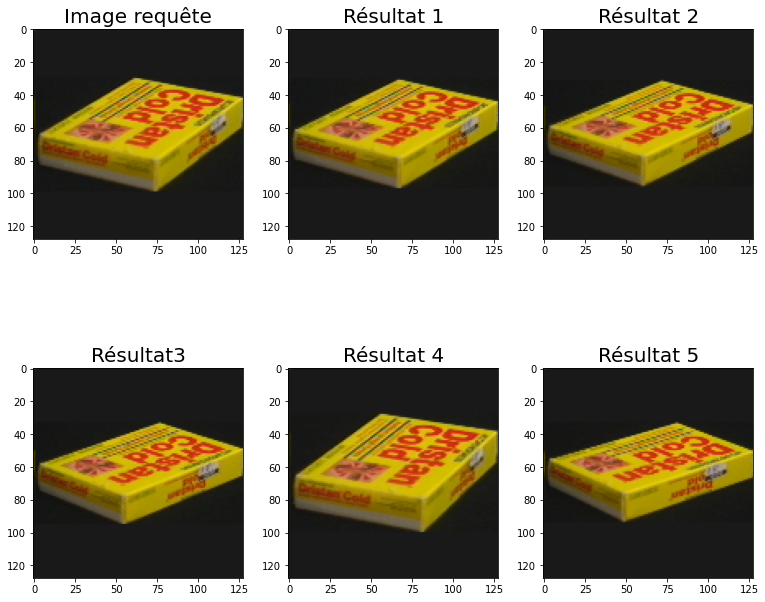

In [18]:
# Resultats
f, a = plt.subplots(2, 3, figsize=(10, 10))
f.tight_layout()

a[0][0].imshow(img_rgb)
a[0][0].set_title('Image requête', fontsize=20)

a[0][1].imshow(t[0])
a[0][1].set_title('Résultat 1', fontsize=20)


a[0][2].imshow(t[1])
a[0][2].set_title('Résultat 2', fontsize=20)

a[1][0].imshow(t[2])
a[1][0].set_title('Résultat3', fontsize=20)

a[1][1].imshow(t[3])
a[1][1].set_title('Résultat 4', fontsize=20)

a[1][2].imshow(t[4])
a[1][2].set_title('Résultat 5', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Test Rechercher une image à partir de son nom

In [19]:
#HISTOGRAMMES = imagesHistogram(IMAGES)
#HUMOMENTS = descripteursHuMoment(IMAGES)

In [ ]:
print("Rechercher une Image")
print("Exemple: obj95__215.png")
image = (str(input("Veuillez inserer le nom d'une image: ")))
N = (int(input("Nombre total d'images à renvoyer: ")))

# Chemin complet vers le script en cours d'excecutin
fichier_courant = os.path.abspath('')

# Contatener avec le nom de la base de données
source_image = "coil-100/"+ image


if source_image not in DATA:
    print("Images Inexistante. Saisissez un nom correct")
else:
    # Enlever l'image requete
    IMAGES = enleverImageReq(DATA, source_image)
    HISTOGRAMMES = imagesHistogram(IMAGES)
    HUMOMENTS = descripteursHuMoment(IMAGES)
    hist_requete, hu_requete = histHuImageRequete(source_image)
    DISTANCES_HIST = compareHis(HISTOGRAMMES, hist_requete)
    DISTANCES_HU = compareHu(HUMOMENTS, hu_requete)
    SCORES = similarite(DISTANCES_HIST, DISTANCES_HU)
    
    # Recuperation du top N -> items() slicing 
    #N = 5
    resultats = dict(list(sorted(SCORES.items(), key=lambda x: x[1]))[0: N])
    print("")
    print("Image Requete: {}".format(os.path.splitext(source_image.split("/")[1])[0]))
    print("")
    print("Résultats:")
    k=1
    for i, j in resultats.items():
        print(" {k}-{c} ....... distance = {a} ".format(k=k, a = j, c = os.path.splitext(i.split("/")[1])[0]))
        k+=1

Rechercher une Image
Exemple: obj95__215.png
